In [22]:
suppressPackageStartupMessages({
  library(dplyr)
  library(ggplot2)
  library(cowplot)
  library(magrittr)
  library(dataorganizer)
  library(readr)

  devtools::load_all()
})

theme_set(theme_bw())

ℹ Loading cellAdmixNotebooks


In [2]:
data <- prepare_brain_tx_and_meta()
cell_annot <- data[[1]]
df <- data[[2]]

In [3]:
so_rna <- prepare_brain_scrna()

In [5]:
base_dir <- base_dir <- CachePath('brain_scaled_dat4/')

k_joint <- c(5,15,20,30)
k_ct <- c(5)

In [7]:
# load NMF and CRF results
res <- load_nmf_crf_multi(k_joint, k_ct, base_dir)
all_nmf <- res[[1]]
crf_all <- res[[2]]

In [8]:
# load saved enrichment results
enr_res_all <- readRDS(paste0(base_dir,'enrich_results.rds'))

In [9]:
# load and extract bridge results
all_ctypes <- unique(cell_annot$celltype)
bridge_res_all <- extract_bridge_multi(all_nmf,all_ctypes=all_ctypes,
                                       dir=base_dir,bridge_pthresh=.2,
                                       bridge_adj_pvals=FALSE)

In [10]:
fp_checks <- check_fp_multi(
  df,cell_annot,crf_all,enr_res_all=enr_res_all, bridge_res_all=bridge_res_all,
  do_clean=TRUE, knn_k=100, median_thresh=.2
)
annot_res_all <- fp_checks[[1]]
orig_nms_all <- fp_checks[[2]]

In [12]:
# compute cell adj mat for scores calculation
df$cell_type <- df$celltype
sc_ctypes <- unique(so_rna$cell_type)
df_ct_match <- df[df$cell_type %in% sc_ctypes,]
cell_adj_df <- estimate_cell_adjacency(df_ct_match, random.shift=1e-2, n.cores=10)

In [13]:
dbl_score_params <- list(
  signal_thres=0.25,
  exclude_genes=NULL,
  p.c=.25,
  min.expr.frac=0.05,
  exclude.cell.types=c('Pericytes'),
  max.prob.high=0.01
)

In [14]:
# compute admixture probability scores
scores_final_df <- suppressWarnings({
  get_scores_multi(annot_res_all,orig_nms_all,dbl_score_params,
                   df,so_rna,crf_all,cell_adj_df,n.cores=12)
})

Normalizing layer: counts



In [57]:
## saving all scores
# saveRDS(scores_final_df,file=paste0(base_dir,'scores_final_df.rds'))
# scores_final_df <- readRDS(file=paste0(base_dir,'scores_final_df.rds'))

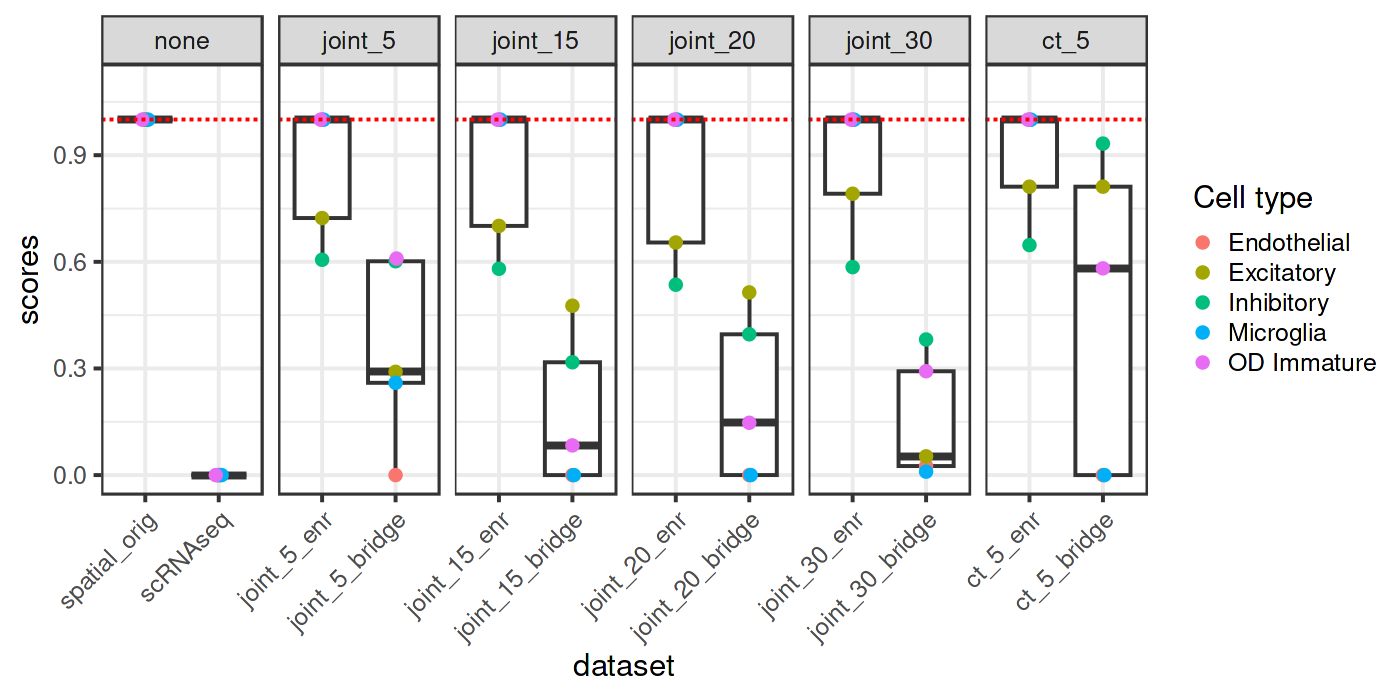

In [18]:
options(repr.plot.width = 7, repr.plot.height = 3.5, repr.plot.res = 200)

p <- plot_ct_av_norm_scores(scores_final_df,trim_level=.4,min_mean_thresh = 1e-3)
p

In [24]:
res_nm <- 'joint_15_bridge'
res_nm_splt <- strsplit(res_nm,split='_')[[1]]
f_rm <- annot_res_all[[res_nm]]
crf_res <- crf_all[[paste0(res_nm_splt[[1]],'_',res_nm_splt[[2]])]]
scores_orig <- scores_final_df[scores_final_df$dataset=='spatial_orig',]
scores_cln <- scores_final_df[scores_final_df$dataset==res_nm,]

plts <- plot_cell_score_ratios(
  scores_orig, scores_cln, f_rm, df, crf_res, upper.lim=1.5, min.mean.thresh=1e-3
)

Picking joint bandwidth of 0.0871



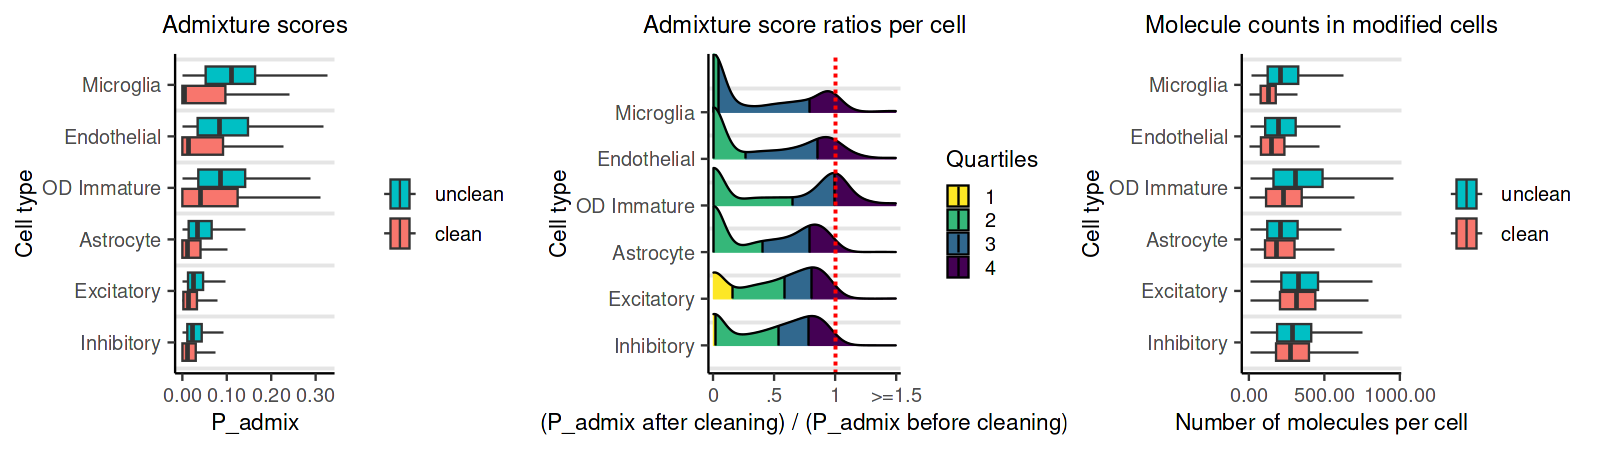

In [25]:
options(repr.plot.width = 8, repr.plot.height = 2.25, repr.plot.res = 200)
fig <- plot_grid(plotlist=plts[c(1,2,4)], nrow=1, align='h')
fig

In [28]:
write_rds(plts[c(1,2,4)], CachePath("./brain_cell_score_ratios2.rds"))

In [27]:
# saving an original counts version of the data
so_spatial_orig <- get_counts_meta_seurat(df, normalize=TRUE)
write_rds(so_spatial_orig, paste0(base_dir,'so_spatial_orig.rds'))

Normalizing layer: counts



In [29]:
# saving a cleaned counts version of the data
k <- 15
f_rm <- annot_res_all[[paste0('joint_',k,'_bridge')]]

# clean the df
df$factor <- crf_res[,1]
df_cln <- df[!(paste(df$factor, df$celltype, sep = "_") %in% f_rm), ]

# make and save a counts version of df_cln
so_spatial_cln <- get_counts_meta_seurat(df_cln,normalize=TRUE)
write_rds(so_spatial_cln, paste0(base_dir,'so_spatial_cln_',k,'_full.rds'))

Normalizing layer: counts

